In [1]:
import os
import glob
import warnings

import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

from dataset import ClassificationDataset, CLASS_MAP
from model import create_classifier
from config import *

# Ignore warnings
warnings.filterwarnings("ignore")

/home/said/anaconda3/envs/ocr2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Helper functions

In [2]:
CLASS_NAMES = {
    v : k for k, v in CLASS_MAP.items()
}

def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


def visualize_model(model, test_dataloader, num_images=6, device=DEVICE):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(12, 8))

    with torch.no_grad():
        for i, sample in enumerate(test_dataloader):
            inputs = sample['image']
            inputs = inputs.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            preds = preds.item()

            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title(f'predicted: {CLASS_NAMES[preds]}')

            imshow(inputs.cpu()[0])

            if images_so_far == num_images:
                return

In [3]:
test_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(MEANS, STDS)
])
test_paths = glob.glob(f'{ROOT_DIR}/test_images/*')
val_dataset = ClassificationDataset(image_paths=test_paths, transform=test_transform)
test_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=NUM_WORKERS)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

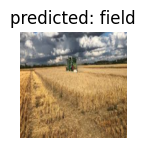

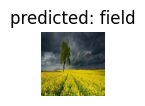

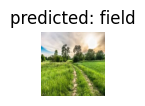

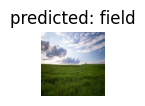

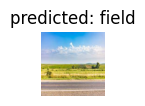

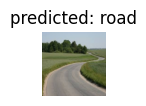

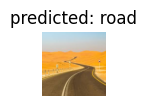

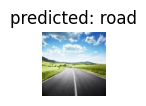

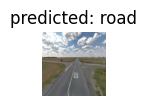

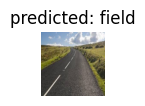

In [4]:
# init the model weights 
model = create_classifier(pretrained=True)
model = model.to(DEVICE)
model.load_state_dict(torch.load(os.path.join(SAVE_DIR, 'best.pt'), map_location=DEVICE))
model.eval()
visualize_model(model, test_dataloader, num_images=10, device=DEVICE)

The model is quite good when the images contain only a road or only a field but when the image has both roads and fields at the same time (ex a filed is visible in the background of a road) the model seems to make a wrong prediction. 

This is merely a demonstration of how it could be done, there many things to tune and explore. Mainly the hyperparameters need more tuning.

To overcome this, one could try adding more data augmentations, try different backbones, use pre-trained foundational models like CLIP/DINO to get a good set of features then add a classifier on top of them.


The time constraint does not allow to try this interesting ideas!